# Refinement Supervision Testing

#### Overview
In the LoFTR (Local Feature Transformer) framework, the refinement of coarse matches is a crucial second step. This refinement process involves determining the specific pixel in crop_2 that aligns with the central pixel of a given patch in crop_1. Notably, this alignment is assessed within a 16x16 patch in the fine feature space. To enhance neural network compatibility, we utilize relative coordinates centered around the midpoint of each patch.

#### Testing Strategy
To verify the accuracy and efficacy of our dataset implementation within the LoFTR framework, we propose the following testing methodology:

1. Recreate the pixel mapping process from Mid pixels in patches of crop_1 to their corresponding pixels in crop_2, leveraging only the match_matrix and relative_coordinates. These are the two key variables accessible during the test phase. Considering that each fine feature symbolizes a 4x4 pixel area in the original crop, the remapped pixels should ideally align within a 4-pixel accuracy range.
2. Evaluate the validity of the L2 loss as implemented in the original LoFTR model, specifically checking whether it accurately returns a value of 0 for perfect predictions and behaves as expected under various conditions.

In [1]:
import sys

sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain")
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain\\source")

In [2]:
import torch
from source.datasets.brain_dataset import BrainDataset
from source.visualization.image_visualization import (
    plot_images_with_matches_via_mapping,
)

In [3]:
images_directory = (
    "C:\\Users\\robin\\Documents\\HyperBrain\\data\\cyto_downscaled_3344_3904"
)
train = False
patch_size = 16
dataset = BrainDataset(
    images_directory=images_directory, train=train, patch_size=patch_size
)

In [4]:
(
    image_1_crop,
    image_2_crop,
    match_matrix,
    relative_coordinates,
    crop_coordinate_mapping,
) = dataset[0]

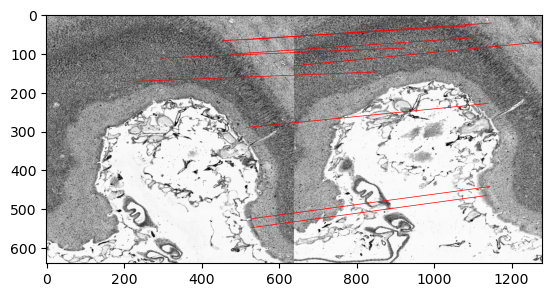

In [5]:
plot_images_with_matches_via_mapping(
    image_1=image_1_crop,
    image_2=image_2_crop,
    coordinate_mapping=crop_coordinate_mapping,
    number_of_matches=10,
    sample_keypoints_randomly=True,
)

#### Reproduce mid_pixel mappings of crop_coordinate_mapping using match_matrix and relative_coordinates

In [6]:
# Get matched patches in crop 1 and crop 2
crop_1_patch_indices = match_matrix.nonzero()[:, 0]  # Get all patch indices in crop 1
crop_2_patch_indices = match_matrix.nonzero()[:, 1]  # Get all patch indices in crop 2

In [7]:
from source.data_processing.patch_processing import get_patch_coordinates

half_patch_size = patch_size // 2
# Get mid point of patches in crop 1 and crop 2
crop_1_patch_mid_indices = (
    get_patch_coordinates(patch_indices=crop_1_patch_indices)
    + torch.Tensor([half_patch_size, half_patch_size]).long()
)  # Get all patch coordinates in crop 1 and add 8 to get the mid point of the patch
crop_2_patch_mid_indices = (
    get_patch_coordinates(patch_indices=crop_2_patch_indices)
    + torch.Tensor([half_patch_size, half_patch_size]).long()
)  # Get all patch coordinates in crop 2 and add 8 to get the mid point of the patch

In [8]:
from source.data_processing.transformations import (
    translate_fine_to_coarse,
    translate_coarse_to_fine,
)

crop_1_patch_mid_indices_fine = translate_fine_to_coarse(
    fine_coordinates=crop_1_patch_mid_indices, fine_size=640, coarse_size=160
)
crop_2_patch_mid_indices_fine = translate_fine_to_coarse(
    fine_coordinates=crop_2_patch_mid_indices, fine_size=640, coarse_size=160
)

In [23]:
crop_1_patch_mid_indices_fine.shape, relative_coordinates.shape

(torch.Size([1450, 2]), torch.Size([1450, 2]))

### Interpretation relative coordinates

|          |         |       |         |        |
|----------|---------|-------|---------|--------|
| -1, -1   | -0.5, -1| 0, -1 | 0.5, -1 | 1, -1  |
| -1, -0.5 | -0.5,-0.5| 0, -0.5| 0.5, -0.5| 1, -0.5|
| -1, 0    | -0.5, 0 | 0, 0  | 0.5, 0  | 1, 0   |
| -1, 0.5  | -0.5, 0.5| 0, 0.5| 0.5, 0.5| 1, 0.5 |
| -1, 1    | -0.5, 1 | 0, 1  | 0.5, 1  | 1, 1   |

The 16x16 pixel patch is represented by 4x4 fine features. For architectural reasons the window_size need to be odd (5 in this case). This means that the last row and column are never matched in ground truth. Lets double check this:

In [24]:
relative_coordinates.max()

tensor(0.5000)

In [11]:
window_size = 5
offset = relative_coordinates * ((window_size - 1) / 2)

# Reproduced coordinates of matches in crop 2
reproduced_matches_crop_2 = translate_coarse_to_fine(
    coarse_coords=crop_2_patch_mid_indices_fine + offset,
    coarse_size=160,
    fine_size=640,
)
reproduced_matches_crop_2

tensor([[  4,  16],
        [ 20,  12],
        [ 36,  12],
        ...,
        [564, 532],
        [580, 532],
        [600, 528]])

In [15]:
ground_truth_matches_crop_2 = crop_coordinate_mapping[
    crop_1_patch_mid_indices[:, 1], crop_1_patch_mid_indices[:, 0]
]
ground_truth_matches_crop_2

tensor([[  4.7468,  17.0056],
        [ 21.4346,  15.4159],
        [ 38.1224,  13.8262],
        ...,
        [566.6934, 534.7034],
        [583.3811, 533.1135],
        [600.0688, 531.5239]])

We 'scaled' the coordinates to the fine feature size of 1/4 of the original image size. This means one fine feature represents a 4x4 pixel window in the original image. Therefore reproduced_matches_crop_2 should deviate at most 4 pixels from the corresponding ground truth (Note this is not the euclidean distance. We simply compare x-coordinates and y-coordinates separated from each other):

In [25]:
(ground_truth_matches_crop_2 - reproduced_matches_crop_2).max()

tensor(3.9979)

In [36]:
torch.norm(ground_truth_matches_crop_2 - reproduced_matches_crop_2, dim=1).mean()

tensor(3.0643)

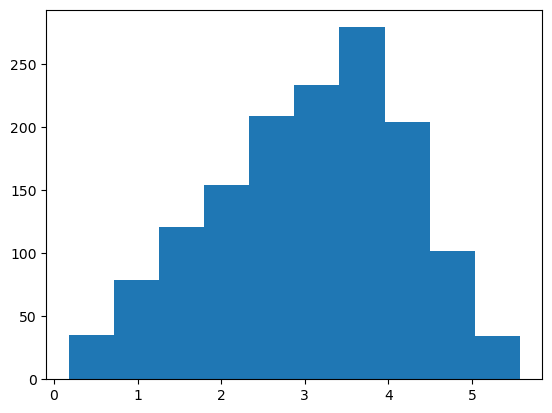

In [39]:
import matplotlib.pyplot as plt

plt.hist(torch.norm(ground_truth_matches_crop_2 - reproduced_matches_crop_2, dim=1))
plt.show()

NOTE: This deviation is a bias part of the supervision! This is not learnable - the model should, in theory, be not able to predict better than that!

### Check the refinement loss

In [27]:
from source.loftr.loss import fine_loss

Test with ground truth

In [30]:
fine_loss(
    coordinates_predicted=relative_coordinates,
    coordinates_ground_truth=relative_coordinates,
)

tensor(0.)

Test with Offsets

In [31]:
offset = torch.tensor([[0.1, 0.1]])
fine_loss(
    coordinates_predicted=relative_coordinates + offset,
    coordinates_ground_truth=relative_coordinates,
)

tensor(0.1414)

Test with Increasing Distances

In [32]:
for i in range(1, 5):
    offset = torch.full_like(relative_coordinates, i * 0.1)
    loss = fine_loss(
        coordinates_predicted=relative_coordinates + offset,
        coordinates_ground_truth=relative_coordinates,
    )
    print(f"Offset: {i * 0.1}, Loss: {loss.item()}")

Offset: 0.1, Loss: 0.141421377658844
Offset: 0.2, Loss: 0.2828426659107208
Offset: 0.30000000000000004, Loss: 0.4242640435695648
Offset: 0.4, Loss: 0.5656853318214417


Test with Random Coordinates

In [36]:
random_pred = (
    2 * torch.rand_like(relative_coordinates) - 1
)  # Scale to [0, 2] and shift to [-1, 1]
random_gt = (
    2 * torch.rand_like(relative_coordinates) - 1
)  # Scale to [0, 2] and shift to [-1, 1]
fine_loss(coordinates_predicted=random_pred, coordinates_ground_truth=random_gt)

tensor(1.0264)

Test with Large and Small Values

In [34]:
large_offset = torch.tensor([[100, 100]])
small_offset = torch.tensor([[0.001, 0.001]])
large_loss = fine_loss(
    coordinates_predicted=relative_coordinates + large_offset,
    coordinates_ground_truth=relative_coordinates,
)
small_loss = fine_loss(
    coordinates_predicted=relative_coordinates + small_offset,
    coordinates_ground_truth=relative_coordinates,
)
print(f"Large Loss: {large_loss.item()}, Small Loss: {small_loss.item()}")

Large Loss: 141.42135620117188, Small Loss: 0.001414199941791594


Test with Zero and Near-Zero Coordinates

In [35]:
zero_coords = torch.zeros_like(relative_coordinates)
near_zero_coords = torch.full_like(relative_coordinates, 1e-6)
zero_loss = fine_loss(
    coordinates_predicted=zero_coords, coordinates_ground_truth=zero_coords
)
near_zero_loss = fine_loss(
    coordinates_predicted=near_zero_coords, coordinates_ground_truth=near_zero_coords
)
print(f"Zero Loss: {zero_loss.item()}, Near-Zero Loss: {near_zero_loss.item()}")

Zero Loss: 0.0, Near-Zero Loss: 0.0
